# Evaluation of drug2ways using AUC-ROC
This notebook evaluates the predictions for all drug-disease pairs existing in the two networks presented in the case scenario. We employ AUC-ROC as a metric while keeping in mind the shortcomings of using this metric given the nature of the predictions and data (see below). We also evaluate both versions of the algorithm (simple and all paths) and find almost no differences using this metric although there are differences when we look at the top-ranked prioritized pairs, as demonstrated in the paper.

Keep in mind:
- The number of positive labels is approximately 3% for both networks. Thus, the dataset is significantly imbalanced.
- We are exclusively interested in the top-ranked drug-disease pairs. In order to select a threshold for the prioritization criteria, we evaluated a range of thresholds on all drug-disease pairs.
- We evaluate drug2ways by aggregating the scores of different lmax values together (in this case we used the same lmax presented in the case scenario of the paper).


In [1]:
import os
import json
import getpass
import sys
import time
from collections import Counter, defaultdict
import itertools as itt
from statistics import mean

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 200

In [4]:
getpass.getuser()

'dfernandez'

In [5]:
sys.version

'3.7.7 (v3.7.7:d7c567b08f, Mar 10 2020, 02:56:16) \n[Clang 6.0 (clang-600.0.57)]'

In [6]:
time.asctime()

'Fri Oct 16 13:35:05 2020'

Get true positive pairs from Clinicaltrials.gov data

In [7]:
clinical_trials_openbiolink = pd.read_csv(
    "./validation_openbiolink.tsv",
    sep="\t",
)

#Positive labels for AUC calculation
positive_labels_openbiolink = [
    (f"PUBCHEM.COMPOUND:{row['cid_id']}", row['do_id'])
    for _, row in clinical_trials_openbiolink.iterrows()
]

clinical_trials_inhouse = pd.read_csv(
    "./validation_custom.tsv",
    sep="\t",
)

#Positive labels for AUC calculation
positive_labels_inhouse = [
    (f"drugbank:{row['drugbank_id']}", f"UMLS:{row['umls_cui']}")
    for _, row in clinical_trials_inhouse.iterrows()
]

Get all drug-disease pairs

In [8]:
source_nodes_openbiolink = pd.read_csv(
    "../data/source_nodes_openbiolink.tsv",
    sep="\t",
    header=None,
)[0].tolist()

target_nodes_openbiolink = pd.read_csv(
    "../data/target_nodes_openbiolink.tsv",
    sep="\t",
    header=None,
)[0].tolist()

source_nodes_inhouse = pd.read_csv(
    "../data/source_nodes_custom.tsv",
    sep="\t",
    header=None,
)[0].tolist()

target_nodes_inhouse = pd.read_csv(
    "../data/target_nodes_custom.tsv",
    sep="\t",
    header=None,
)[0].tolist()

Number of positive labels relative to all drug-disease pairs (%)

In [9]:
print(
    f'OpenBioLink network: {round(len(positive_labels_openbiolink) / (len(source_nodes_openbiolink) * len(target_nodes_openbiolink)) * 100, 2)}% of positive labels'
)
print(
    f'In-House network: {round(len(positive_labels_inhouse) / (len(source_nodes_inhouse) * len(target_nodes_inhouse)) * 100, 2)}% of positive labels'
)

OpenBioLink network: 3.2% of positive labels
In-House network: 3.76% of positive labels


Load results and calculate average score for each pair through different lmax

In [10]:
def normalize_score(score):
    """Normalize score from [0 to 1]."""
    # Absolute value makes -1 = 1 as they have the same weight
    # Example 50/50 inhibition/activation paths will be normalized to 0. (the ones with the less score)
    # 75/25 will be normalized to 0.5 (medium prioritization by drug2ways)
    # 25/75 will be normalized to 0.5 (medium prioritization by drug2ways)
    # 100/0 will be normalized to 1.0 (max prioritization by drug2ways)
    # 0/100 will be normalized to 1.0 (max prioritization by drug2ways)
    return abs((1 - (-1)) * (score - 0) / (1 - 0) -1)

def get_scores_for_pair(results, drug_nodes, disease_nodes):
    """Get scores for each pair as a pair to list dict.
    
    :param results: raw results from the JSON files
    """
    pairs_to_scores = defaultdict(list)
    
    # Iterate over the results of each lmax
    for lmax, pairs in results.items():
        
        # Iterate over each pair and get the score
        all_scores_for_lmax = {
            (pair['source'], pair['target']): normalize_score(pair['relative_activation'])
            for pair in pairs
        }
                
        # give the most negative value (-1) to pairs without a path
        # since they have less priorization than any drug-disease pair with a path
        for (drug, disease) in itt.product(drug_nodes, disease_nodes):
            pairs_to_scores[(drug, disease)].append(all_scores_for_lmax.get((drug, disease), -1))
        
    return {
        pair: mean(scores)
        for pair, scores in pairs_to_scores.items()
    }

def prepare_results(path_dir, prefix, drug_nodes, disease_nodes):
    """Parse directory with results."""
    results = {}
    
    for file in os.listdir(path_dir):
        
        if not file.endswith(".json") or not file.startswith(f"{prefix}all_against_all_lmax_"):
            continue

        lmax = int(file.replace(f"{prefix}all_against_all_lmax_", "").replace(".json", ""))

        with open(os.path.join(path_dir, file), 'r') as f:
            results[lmax] = json.load(f)

    # sort keys by lmax in case they have not been read in order
    results = {
        k: results[k]
        for k in sorted(results.keys())
    }
    
    if not results:
        raise ValueError("Couldnt load any results. Please ensure the valid path is given.")
        
    return get_scores_for_pair(results, drug_nodes, disease_nodes)

Get scores for each network/drug2ways variant (simple/cycles)

In [11]:
openbiolink_auc_simple = prepare_results(
    path_dir=f"/Users/{getpass.getuser()}/Downloads/drug2ways/simple_paths/openbiolink/",
    prefix="openbiolink",
    drug_nodes=source_nodes_openbiolink,
    disease_nodes=target_nodes_openbiolink,
)

openbiolink_auc_cycles = prepare_results(
    path_dir=f"/Users/{getpass.getuser()}/Downloads/drug2ways/cycles/openbiolink/",
    prefix="openbiolink",
    drug_nodes=source_nodes_openbiolink,
    disease_nodes=target_nodes_openbiolink,
)

inhouse_auc_simple = prepare_results(
    path_dir=f"/Users/{getpass.getuser()}/Downloads/drug2ways/simple_paths/custom/",
    prefix="custom_",
    drug_nodes=source_nodes_inhouse,
    disease_nodes=target_nodes_inhouse,
)

inhouse_auc_cycles = prepare_results(
    path_dir=f"/Users/{getpass.getuser()}/Downloads/drug2ways/cycles/custom/",
    prefix="custom",
    drug_nodes=source_nodes_inhouse,
    disease_nodes=target_nodes_inhouse,
)

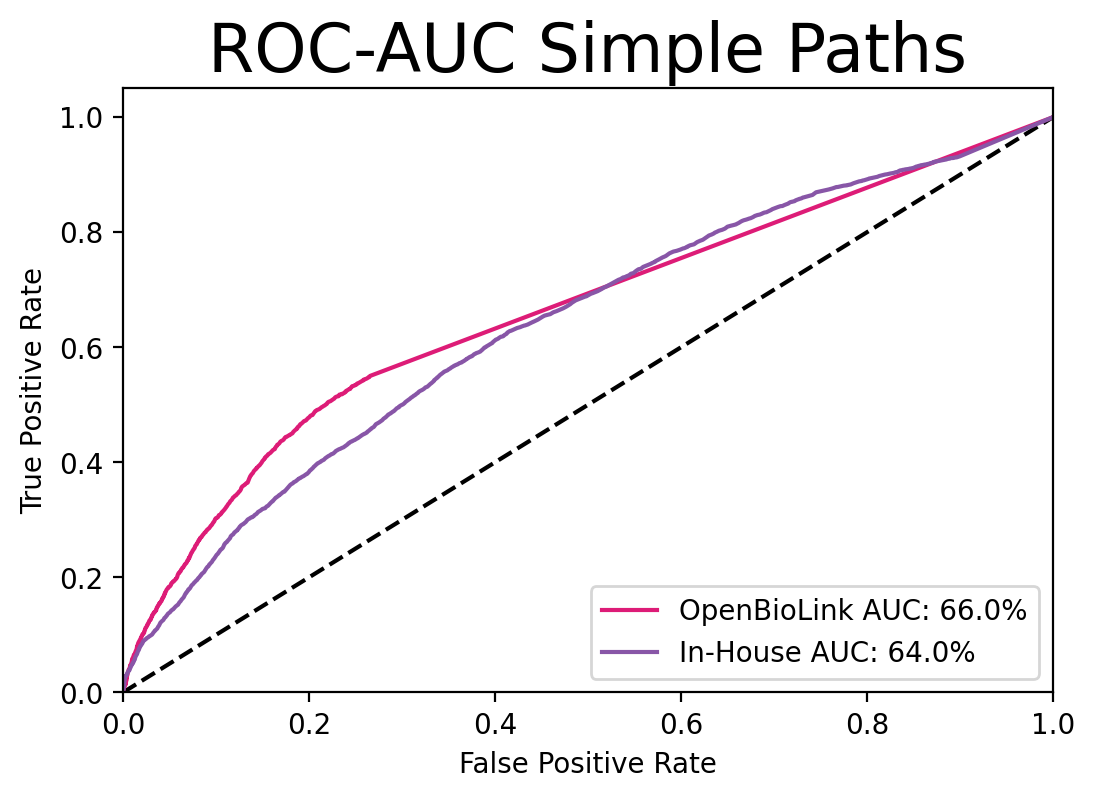

In [12]:
plt.figure()

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

for dataset, line_label, color in zip(
    [openbiolink_auc_simple, inhouse_auc_simple], 
    ['OpenBioLink', 'In-House'],
    ['#dd1c77', '#8856a7'],
):
    
    # Choose the right set of positive labels depending on the network
    if line_label.startswith('OpenBioLink'):
        positive_labels = positive_labels_openbiolink
    else:
        positive_labels = positive_labels_inhouse

    # Populate labels and scores
    scores = []
    labels = []
    
    for drug_disease_pair, score in dataset.items():

        scores.append(score)
        labels.append(
            1 if drug_disease_pair in positive_labels else 0
        )

    roc_auc = roc_auc_score(labels, scores)
    fpr, tpr, _ = roc_curve(labels, scores)
    
    plt.plot(fpr, tpr, label=f'{line_label} AUC: {round(roc_auc, 2) * 100}%', color=color)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Simple Paths', fontdict={'fontsize': 24})
plt.legend(loc="lower right")
plt.show()

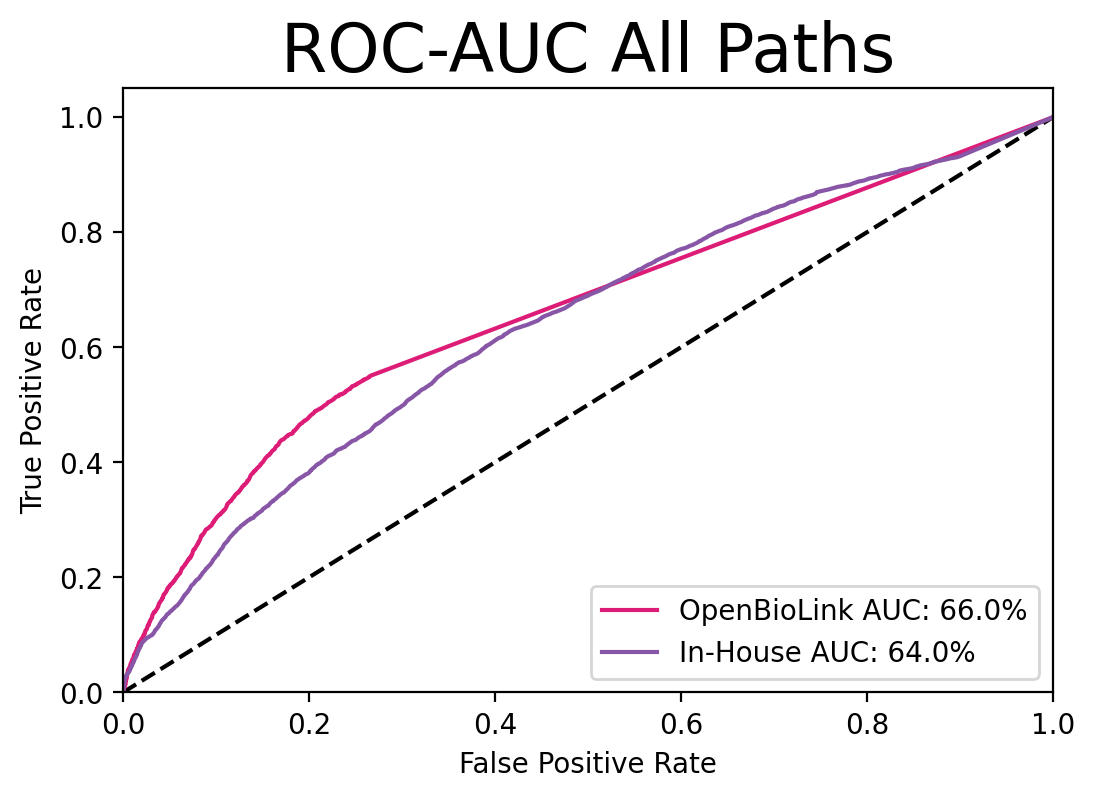

In [13]:
plt.figure()

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

for dataset, line_label, color in zip(
    [openbiolink_auc_cycles, inhouse_auc_cycles], 
    ['OpenBioLink', 'In-House'],
    ['#dd1c77', '#8856a7'],
):
    
    # Choose the right set of positive labels depending on the network
    if line_label.startswith('OpenBioLink'):
        positive_labels = positive_labels_openbiolink
    else:
        positive_labels = positive_labels_inhouse

    # Populate labels and scores
    scores = []
    labels = []
    
    for drug_disease_pair, score in dataset.items():

        scores.append(score)
        labels.append(
            1 if drug_disease_pair in positive_labels else 0
        )

    roc_auc = roc_auc_score(labels, scores)
    fpr, tpr, _ = roc_curve(labels, scores)
    
    plt.plot(fpr, tpr, label=f'{line_label} AUC: {round(roc_auc, 2) * 100}%', color=color)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC All Paths', fontdict={'fontsize': 24})
plt.legend(loc="lower right")
plt.show()